# Dog Breed Prediction

Nesse projeto, iremos entender como usar o Keras e TensorFlow para construir, treinar e testar uma Rede Neural Convolucional capaz de identificar a raça de um cão em uma imagem. Esse é um problema de **aprendizado supervisionado**, mais especificamente um problema de ***classificaçõo múltipla***.

Vamos conectar ao Kaggle usando Kaggle API que pode ser baixada pelas configurações da sua conta.

In [1]:
#Install the Kaggle API client
!pip install -q kaggle

In [8]:
# The Kaggle API client expects this file to be in ~/.kaggle, so move it there

# This permissions change avoids a warning on Kaggle tool startup
#!chmod 600 /kaggle/kaggle.json

Para guardar os dados, iremos criar um novo diretório 

In [9]:
#Creating directory and changing the current working directory
!mkdir dog_dataset
%cd dog_dataset

C:\Users\marioestevao\OneDrive\Área de Trabalho\100-projects-data-science\2 - Dog Breed Prediction\dog_dataset


In [12]:
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           1558          6  0.1764706        


Serch option: -s

Nós também podemos procurar diferentes opções de pesquisa como competitions, notebooks, kernels, datasets, etc.

In [ ]:
#Downloading dataset and coming out of directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

Descompactando arquivos (para quem está no Google Colab)

In [ ]:
# Unzipping downloaded file and removing unusable file
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/samplesubmission.csv

# --Made manually

## Pre-processamento

In [43]:
# Important library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

In [20]:
# Read the labels csv

labels_all = pd.read_csv('dog_dataset/labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [23]:
# Visualize the number of each breeds
breeds_all = labels_all['breed']
breeds_all.value_counts().head()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: breed, dtype: int64

Temos 120 tipos de raças de cães no dataset.

Por isso, vamos trabalhar com apenas as 5 maiores.

In [28]:
# Selecting first 5 breeds
CLASS_NAMES = ['scottish_deerhound', 'maltese_dog', 'afghan_hound', 'entlebucher', 'bernese_mountain_dog']
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,80,01ee3c7ff9bcaba9874183135877670e,entlebucher
4,88,021b5a49189665c0442c19b5b33e8cf1,entlebucher


In [29]:
labels

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,80,01ee3c7ff9bcaba9874183135877670e,entlebucher
4,88,021b5a49189665c0442c19b5b33e8cf1,entlebucher
...,...,...,...
583,10154,fe3e760d763e186541e18f303cd7caca,bernese_mountain_dog
584,10158,fe50bac6c389d137ea01c9cfc7346ca8,scottish_deerhound
585,10178,fef5d4cdaf50cf159102e803c7d6aa9c,bernese_mountain_dog
586,10200,ff7d9c08091acc3b18b869951feeb013,maltese_dog


Como este é um problema de **classificação**, precisamos fazer o *one-hot enconding* das classes (Que também são nossas variáveis target). Depois, iremos ler as imagens e convertê-las para um numpy array, terminando o processo com uma normalização.

O numpy array vai receber as imagens como se tivessem uma resolução de 224x224, em um campo de três dimensões - Como funciona com *imagens RGB*

In [37]:
# Creating numpy matrix with zeros
X = np.zeros((len(labels), 224, 224, 3), dtype='float32')
Y = label_binarize(labels['breed'], classes= CLASS_NAMES) #One-Hot Encoder

In [41]:
# Reading and converting image to numpy array and normalizing the dataset
for i in tqdm(range(len(labels))):
    img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X[i] = x / 255.0
    
# Print traing image and one-hot encode shape&size
print('\nTrain images shape: ', X.shape,' size: {:,}'.format(X.size))
print('\One-hot encoded output shape: ', Y.shape,' size: {:,}'.format(Y.size))

100%|██████████| 588/588 [00:01<00:00, 373.13it/s]


Train images shape:  (588, 224, 224, 3)  size: 88,510,464
\One-hot encoded output shape:  (588, 5)  size: 2,940


Podemos checar também o formato do nosso One-Hot Encoding

## Modelando

Criaremos uma arquitetura de rede para o modelo. Serão aplicadas diversas camadas diferentes, com filtros diferentes, usando as classes **Conv2D** (Cria um kernel convolucional que espirala com a *layer de input* para produzir tensor de saída - Lembre que estamos usando o TensorFlow), **MaxPool2D** (Técnica de amostragem que pega o máximo valor abaixo da janela definida pela `poolsize`), **Flatten** ('Planifica' o *input* e cria uma saída unidimensional) e **Dense** (Camada que reduz a dimensão dos vetores diretamente ligados aos neurônios da camada anterior. Esta é a camada que gera a saída para cada uma das classes).

In [46]:
# Build
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5), activation='relu', input_shape = (224, 224, 3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 16, kernel_size = (7,7), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5,5), activation='relu', kernel_regularizer='l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(len(CLASS_NAMES), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer = Adam(0.0001), metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 16)      

Parâmetros encontrados no treinamento: **162,749**

### Treinando o modelo

In [47]:
# Splitting the dataset into training and testing datasets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.1)

# Splitting the training dataset into training and validation datasets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)

Vamos treinar o modelo 100 vezes e com um `batch_size` de 128. Aumentar o número de *epochs* pode (Ênfase aqui) aumentar a acurácia. Durante cada epoch, podemos ver como o modelo está performando.

In [48]:
# Training the model
epochs = 100
batch_size = 128

history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (X_val, y_val))

Epoch 1/100
4/4 [==============================] - 17s 4s/step - loss: 5.3833 - accuracy: 0.2340 - val_loss: 5.3554 - val_accuracy: 0.2542
Epoch 2/100
4/4 [==============================] - 15s 4s/step - loss: 5.3328 - accuracy: 0.2723 - val_loss: 5.3086 - val_accuracy: 0.2627
Epoch 3/100
4/4 [==============================] - 15s 4s/step - loss: 5.2832 - accuracy: 0.2809 - val_loss: 5.2620 - val_accuracy: 0.2712
Epoch 4/100
4/4 [==============================] - 15s 4s/step - loss: 5.2345 - accuracy: 0.2553 - val_loss: 5.2163 - val_accuracy: 0.2119
Epoch 5/100
4/4 [==============================] - 15s 4s/step - loss: 5.1865 - accuracy: 0.2426 - val_loss: 5.1718 - val_accuracy: 0.2119
Epoch 6/100
4/4 [==============================] - 15s 4s/step - loss: 5.1378 - accuracy: 0.2468 - val_loss: 5.1297 - val_accuracy: 0.2288
Epoch 7/100
4/4 [==============================] - 15s 4s/step - loss: 5.0897 - accuracy: 0.2532 - val_loss: 5.0881 - val_accuracy: 0.2288
Epoch 8/100
4/4 [==========

4/4 [==============================] - 14s 4s/step - loss: 2.9291 - accuracy: 0.7915 - val_loss: 3.8737 - val_accuracy: 0.4407
Epoch 60/100
4/4 [==============================] - 14s 4s/step - loss: 2.8903 - accuracy: 0.8383 - val_loss: 4.0059 - val_accuracy: 0.3983
Epoch 61/100
4/4 [==============================] - 14s 4s/step - loss: 2.8656 - accuracy: 0.8489 - val_loss: 3.8995 - val_accuracy: 0.4322
Epoch 62/100
4/4 [==============================] - 14s 4s/step - loss: 2.8707 - accuracy: 0.8319 - val_loss: 3.9914 - val_accuracy: 0.3983
Epoch 63/100
4/4 [==============================] - 14s 4s/step - loss: 2.8371 - accuracy: 0.8340 - val_loss: 3.8968 - val_accuracy: 0.4746
Epoch 64/100
4/4 [==============================] - 14s 3s/step - loss: 2.8230 - accuracy: 0.8234 - val_loss: 3.9406 - val_accuracy: 0.4322
Epoch 65/100
4/4 [==============================] - 14s 4s/step - loss: 2.7754 - accuracy: 0.8574 - val_loss: 3.8826 - val_accuracy: 0.4746
Epoch 66/100
4/4 [===============

### Testando

*   Agora, vamos analisar como o modelo está aprendendo em cada epoch

*   Logo depois, testaremos o mesmo.

*   Usaremos a função `predict` para fazer predições com o modelo, juntamente com a acurária do conjunto de teste

Na testagem, visualizaremos um elemento por vez, pois também mostraremos a imagem de cada cachorrom, individualmente.

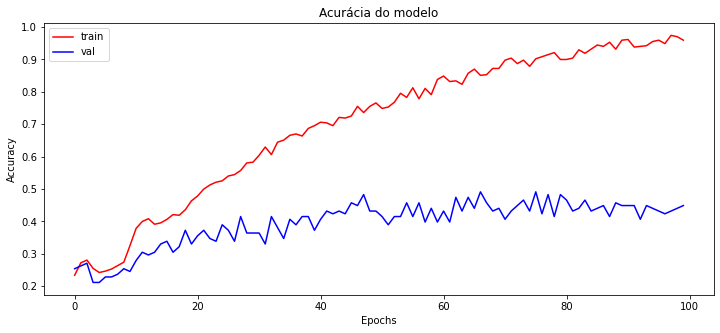

In [49]:
# Plot the training history
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.historytory['val_accuracy'], color='b')
plt.title('Acurácia do modelo')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.show()

O modelo se saiu bem com o dataset de treino, mas não tanto com o de validação, o que pode representar um pouco de *overfit*, ou **superadequação**.

In [54]:
y_pred = model.predict(X_test)
score = model.evaluate(X_test, y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 154ms/step - loss: 2.8232 - accuracy: 0.8475
Accuracy over the test set: 
  84.75 %


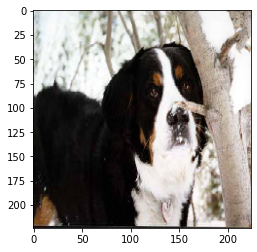

Originally:  scottish_deerhound
Predicted:  scottish_deerhound


In [62]:
# Plotting image to compare
plt.imshow(X_test[42,:,:,:]) # Você pode mudar o doguinho analisado ao trocar o primeiro valor do array
plt.show()

# Finding max value from predition list and comparing original value vs predicted
print('Originally: ', labels['breed'][np.argmax(y_test[0])])
print('Predicted: ', labels['breed'][np.argmax(y_pred[0])])

## Conclusão

O modelo conseguiu atingir, modestamente, as expectativas, mesmo sem nenhuma tunagem de hiperparâmetros. Esse modelo pode ser usado por diversas organizações que trabalham com salvamento e adoção de animais, além de propósitos educacionais.

Made originally by **Pianalytix**

Traduzido e reconstruído por **Samurai**

In [64]:
model.save('dog_breed.h5')